In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((224,224))])

In [3]:
training_data = Flowers102(
    root='',
    split='train',
    transform=transform,
    download=True
)

testing_data = Flowers102(
    root='',
    split='test',
    transform=transform,
    download=True
)

evaluation_data = Flowers102(
    root='',
    split='val',
    transform=transform,
    download=True
)

In [4]:
training_loader = torch.utils.data.DataLoader(training_data,batch_size=4,shuffle=True, num_workers=2)
testing_loader = torch.utils.data.DataLoader(testing_data,batch_size=4,shuffle=False, num_workers=2)

In [5]:
print('Training data has {} instances'.format(len(training_data)))
print('Evaluation data has {} instances'.format(len(evaluation_data)))
print('Testing data has {} instances'.format(len(testing_data)))

Training data has 1020 instances
Evaluation data has 1020 instances
Testing data has 6149 instances


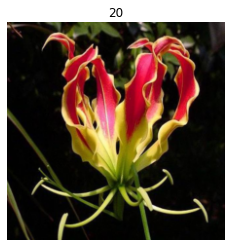

In [6]:
img, label = training_data[160]
np_img = img.permute(1, 2, 0).numpy()
plt.title(label)
plt.imshow((np_img * 255).astype('uint8'))
plt.axis('off')
plt.show()

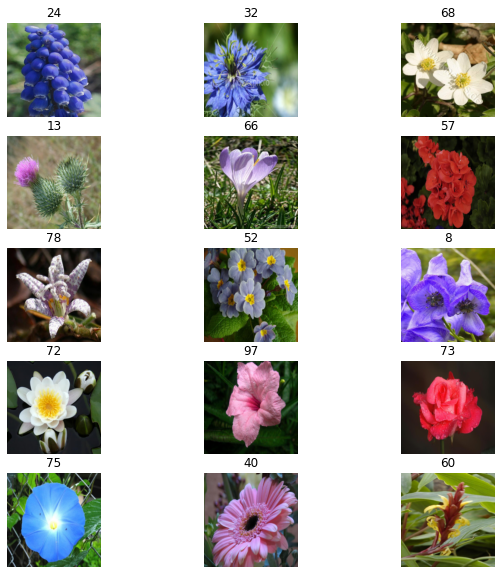

In [7]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    
    np_img = img.permute(1, 2, 0).numpy()
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.imshow((np_img * 255).astype('uint8'))
    plt.axis('off')
plt.show()

In [8]:
# Create a basic NN and see what happens
class FlowerClassifier(nn.Module):
    def __init__(self):
        super(FlowerClassifier, self).__init__()
        self.fc1 = nn.Linear(3 * 224 * 224, 512)
        self.fc2 = nn.Linear(512, 102)
        
    def forward(self,x):
        x = x.view(-1, 3 * 224 * 224)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
training_loader = DataLoader(training_data, batch_size=32, shuffle=True)
evaluation_loader = DataLoader(evaluation_data, batch_size=32, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def train(model, training_loader, evaluation_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        training_loss = 0.0
        for inputs,labels in training_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item() * inputs.size(0)
        
        training_loss /= len(training_loader.dataset)
        
        model.eval()
        evaluation_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs,labels in evaluation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                evaluation_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        evaluation_loss /= len(evaluation_loader.dataset)
        evaluation_accuracy = correct / total
        
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {training_loss:.4f}, Evaluation Loss: {evaluation_loss:.4f}, Val Accuracy: {evaluation_accuracy:.4f}')


model = FlowerClassifier()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, training_loader, evaluation_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Training Loss: 38.2559, Evaluation Loss: 8.7622, Val Accuracy: 0.0245
Epoch 2/10, Training Loss: 4.8707, Evaluation Loss: 4.6466, Val Accuracy: 0.0157
Epoch 3/10, Training Loss: 4.5222, Evaluation Loss: 4.6020, Val Accuracy: 0.0245
Epoch 4/10, Training Loss: 4.5208, Evaluation Loss: 4.5922, Val Accuracy: 0.0245
Epoch 5/10, Training Loss: 4.4895, Evaluation Loss: 4.5814, Val Accuracy: 0.0216
Epoch 6/10, Training Loss: 4.4667, Evaluation Loss: 4.5668, Val Accuracy: 0.0255
Epoch 7/10, Training Loss: 4.4171, Evaluation Loss: 4.5504, Val Accuracy: 0.0275
Epoch 8/10, Training Loss: 4.4040, Evaluation Loss: 4.5250, Val Accuracy: 0.0216
Epoch 9/10, Training Loss: 4.4117, Evaluation Loss: 4.5075, Val Accuracy: 0.0245
Epoch 10/10, Training Loss: 4.3781, Evaluation Loss: 4.4549, Val Accuracy: 0.0333
